In [23]:
from spacepy import pycdf
from PIL import Image, ImageOps
import glob
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sys

In [2]:
cdf = pycdf.CDF("example_data/thg_l1_asf_rank_2008021005_v01.cdf")
cdf_dat = cdf.copy()

In [3]:
# asf -> all sky full
cdf.attrs

<gAttrList:
ADID_ref: NSSD0110 [CDF_CHAR]
Acknowledgement: NASA Contract NAS5-02099 [CDF_CHAR]
Data_type: ASF>All Sky Imager, Full resolution images, High resolution [CDF_CHAR]
Data_version: 1 [CDF_CHAR]
Descriptor: RANK>Rankin Inlet Canada [CDF_CHAR]
Discipline: Space Physics>Magnetospheric Science [CDF_CHAR]
            Space Physics>Ionospheric Science [CDF_CHAR]
File_naming_convention: source_datatype_descriptor [CDF_CHAR]
Generated_by: Harald Frey [CDF_CHAR]
Generation_date: 2006-10-24 [CDF_CHAR]
HTTP_LINK: http://sprg.ssl.berkeley.edu/themis [CDF_CHAR]
           http://aurora.phys.ucalgary.ca/themis [CDF_CHAR]
Instrument_type: Ground-Based VLF/ELF/ULF, Photometrics [CDF_CHAR]
LINK_TEXT: http://sprg.ssl.berkeley.edu/themis [CDF_CHAR]
           http://aurora.phys.ucalgary.ca/themis [CDF_CHAR]
LINK_TITLE: THEMIS GBO portal [CDF_CHAR]
            THEMIS-Canada portal [CDF_CHAR]
Logical_file_id: thg_l1_asf_rank_2008021005_v01 [CDF_CHAR]
Logical_source: thg_l1_asf_rank [CDF_CHAR]
Log

In [4]:
print(cdf)

range_epoch: CDF_EPOCH [2]
thg_asf_rank: CDF_UINT2 [1200, 256, 256]
thg_asf_rank_column: CDF_UINT2 [256] NRV
thg_asf_rank_epoch: CDF_EPOCH [1200]
thg_asf_rank_epoch0: CDF_EPOCH [] NRV
thg_asf_rank_row: CDF_UINT2 [256] NRV
thg_asf_rank_tend: CDF_REAL8 [1200]
thg_asf_rank_time: CDF_REAL8 [1200]


In [5]:
images = np.array(cdf_dat['thg_asf_rank'])
times = np.array(cdf_dat['thg_asf_rank_epoch'])

In [6]:
def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

In [7]:
def process_images(images):
    processed_images = []
    for image in images:
        processed_image = image - np.percentile(image, 1)
        processed_image = processed_image / np.percentile(image, 99)
        processed_image = np.maximum(np.zeros(processed_image.shape), processed_image)
        processed_image = np.minimum(np.ones(processed_image.shape), processed_image)
        processed_images.append(processed_image)
    return np.array(processed_images)

# PCA

In [8]:
# principal components represent the directions of the data that explain a maximal amount of variance, 
# that is to say, the lines that capture most information of the data
from sklearn.decomposition import PCA

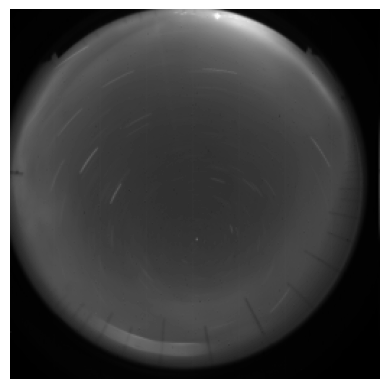

In [13]:
def center_data(X):
    X_mean = np.mean(X, axis=0)
    sub_matrix = np.array([X_mean for i in range(len(X))]) 
    X_center = X - sub_matrix
    return X_center, X_mean

images_processed = process_images(images)
X = images_processed
X, X_mean = center_data(images_processed)
plt.imshow(X_mean, cmap='gray')
plt.axis('off');

In [14]:
nsamples, nx, ny = X.shape
d2_images_processed = X.reshape((nsamples,nx*ny))
pca = PCA(4)
converted_data = pca.fit_transform(d2_images_processed)
converted_data.shape

(1200, 4)

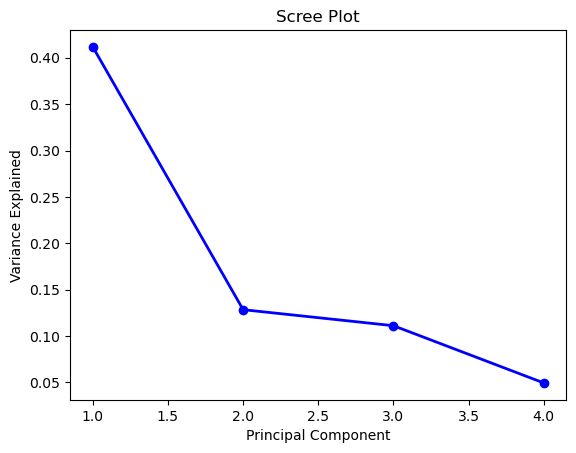

In [15]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

array([[-2.44269078, -1.59797088,  1.50079426, -2.19790492],
       [-2.51023556, -1.72021135,  1.64031088, -2.28880141],
       [-2.57531523, -1.86475359,  1.85251014, -2.44628661],
       ...,
       [23.11799326, 12.71004478,  6.01209172, -1.04397038],
       [22.82140683, 12.80214052,  6.18721147, -0.85938304],
       [22.8630108 , 12.93676839,  6.13407817, -0.57603408]])

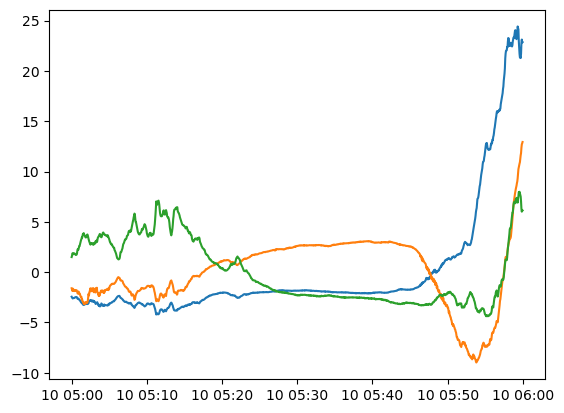

In [16]:
plt.plot(np.array(cdf_dat['thg_asf_rank_epoch']), [(x[0], x[1], x[2]) for x in converted_data])
converted_data

# Classification

In [18]:
def make_png_files(directory, pixels, times):
    images = process_images(pixels)
    
    if not os.path.exists(directory):
        os.mkdir(directory)
    
    for image, time in zip(images, times):
        time_str = time.strftime('%Y%m%d%H%M%S')
        
        image = (image * 255).astype(np.uint8)
                
        im = Image.fromarray(image)
                
        im = ImageOps.grayscale(im)
        
        im.save(f'{directory}/{time_str}.png')

In [17]:
make_png_files("./example_data/rank_asf_2010021005_images", images, times)

In [19]:
sys.path.append(os.path.abspath("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/tame/"))
sys.path.append(os.path.abspath("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/tame/dataHandler"))
from dataHandler import AsimClassifier
torch_data_location = "/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/tame/data/torch/"
clf = AsimClassifier(torch_path=torch_data_location)

In [20]:
image_files = glob.glob("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/example_data/rank_asf_2010021005_images/*.png")

In [38]:
results = clf.classify_images(image_files)

2022-10-27 02:18:29,771 - logger - INFO - Device set to cpu
2022-10-27 02:18:29,771 - logger - INFO - loading pretrained torchvision model
/Users/jeffreysung/mambaforge/envs/substorm/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jeffreysung/mambaforge/envs/substorm/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2022-10-27 02:18:29,805 - logger - INFO - Extracting features


 |==================================================| 100.000% 


In [39]:
results['time'] = results['file'].apply(lambda x: int(re.findall(r'([\d]+)\.png$', x)[0])).sort_values()
results = results.sort_values('time')
results['time'] = times
results = results.reset_index(drop=True)
results

,file,pred,class_0,class_1,class_2,class_3,class_4,class_5,feat_0,feat_1,...,feat_991,feat_992,feat_993,feat_994,feat_995,feat_996,feat_997,feat_998,feat_999,time
0,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,5,0.254699,0.016729,0.001511,0.003607,0.000050,0.723403,-0.400052,1.104706,...,0.976694,0.332226,1.378038,2.291691,-0.825150,0.416034,2.392042,-2.024059,-1.437174,2008-02-10 05:00:00.056
1,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,5,0.343622,0.021893,0.001786,0.004396,0.000074,0.628230,-0.874121,1.002735,...,0.652858,0.144142,1.189651,2.039971,-1.327569,0.144907,2.456404,-1.912802,-1.686884,2008-02-10 05:00:03.056
2,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,5,0.333825,0.016444,0.001569,0.002859,0.000063,0.645240,-0.809856,1.462513,...,0.611134,0.050345,0.991068,1.929310,-1.402712,0.031476,2.424049,-1.832629,-1.279081,2008-02-10 05:00:06.037
3,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,5,0.310003,0.023846,0.001984,0.003009,0.000062,0.661096,-0.542860,1.120307,...,0.839257,-0.127686,1.139992,1.962211,-1.386808,0.193447,2.433990,-2.039683,-1.343469,2008-02-10 05:00:09.067
4,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,5,0.301898,0.017642,0.001831,0.003515,0.000060,0.675054,-0.520117,1.236881,...,0.612783,0.156846,1.179735,2.028704,-1.302800,0.181370,2.403350,-2.135458,-1.277498,2008-02-10 05:00:12.067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,2,0.007827,0.003650,0.987938,0.000062,0.000453,0.000070,1.811769,4.314889,...,-1.618664,-1.488555,2.713171,2.716694,-0.504472,-0.512305,1.698179,-0.827632,1.825926,2008-02-10 05:59:45.021
1196,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,2,0.002947,0.005099,0.991558,0.000067,0.000308,0.000021,2.326236,4.177756,...,-1.628123,-0.614901,2.886859,2.463513,-0.862478,-0.618281,1.978696,-1.355056,2.134870,2008-02-10 05:59:48.031
1197,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,2,0.002682,0.002233,0.994730,0.000033,0.000291,0.000031,1.621883,3.665405,...,-1.516246,-1.151408,2.090205,3.274733,-0.152153,-0.889859,1.423386,-1.351776,1.650556,2008-02-10 05:59:51.061
1198,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,2,0.004963,0.003041,0.991049,0.000087,0.000645,0.000215,0.583689,3.582618,...,-2.003218,-1.179896,2.020087,3.196666,-0.801444,-0.572760,1.655933,-1.731105,1.170657,2008-02-10 05:59:54.011


In [40]:
# input integer between 0 and len(image_list) - 1
def display_single_result(image_list, results, index):
    im = Image.open(image_list[index])
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    class_probabilities = [str(results.iloc[index]["class_"+str(i)]*100) for i in range(6)]
    print("arc with probability " + class_probabilities[0] + "%")
    print("diffuse with probability " + class_probabilities[1] + "%")
    print("discrete with probability " + class_probabilities[2] + "%")
    print("cloud with probability " + class_probabilities[3] + "%")
    print("moon with probability " + class_probabilities[4] + "%")
    print("clear sky with probability " + class_probabilities[5] + "%")

arc with probability 37.89293314341505%
diffuse with probability 6.123602644120893%
discrete with probability 0.5343674095912531%
cloud with probability 0.0936749922974158%
moon with probability 0.010301683111301484%
clear sky with probability 55.345120127464064%


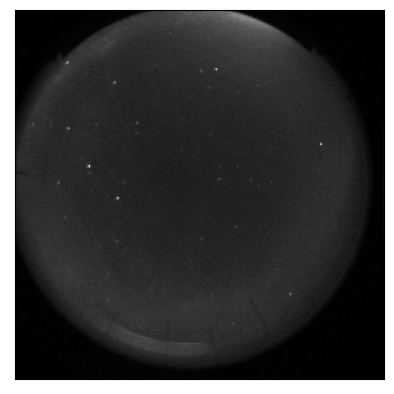

In [41]:
display_single_result(image_files, results, 238)

In [46]:
def plot_probabilities_over_time(results):
    fig = plt.figure(figsize=(24, 8))
    ax = fig.gca()
    plt.title("Aurora Classification Results: RANK ASF 2008-02-10 5:00-6:00")
    plt.ylabel("Probability of Class")
    plt.xlabel("Time")
    plt.ylim(
        ymin=0,
        ymax=1
    )
    plt.plot(results['time'], results['class_0'], label='arc')
    plt.plot(results['time'], results['class_1'], label='diffuse')
    plt.plot(results['time'], results['class_2'], label='discrete')
    plt.plot(results['time'], results['class_3'], label='cloud')
    plt.plot(results['time'], results['class_4'], label='moon')
    plt.plot(results['time'], results['class_5'], label='clear')
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()

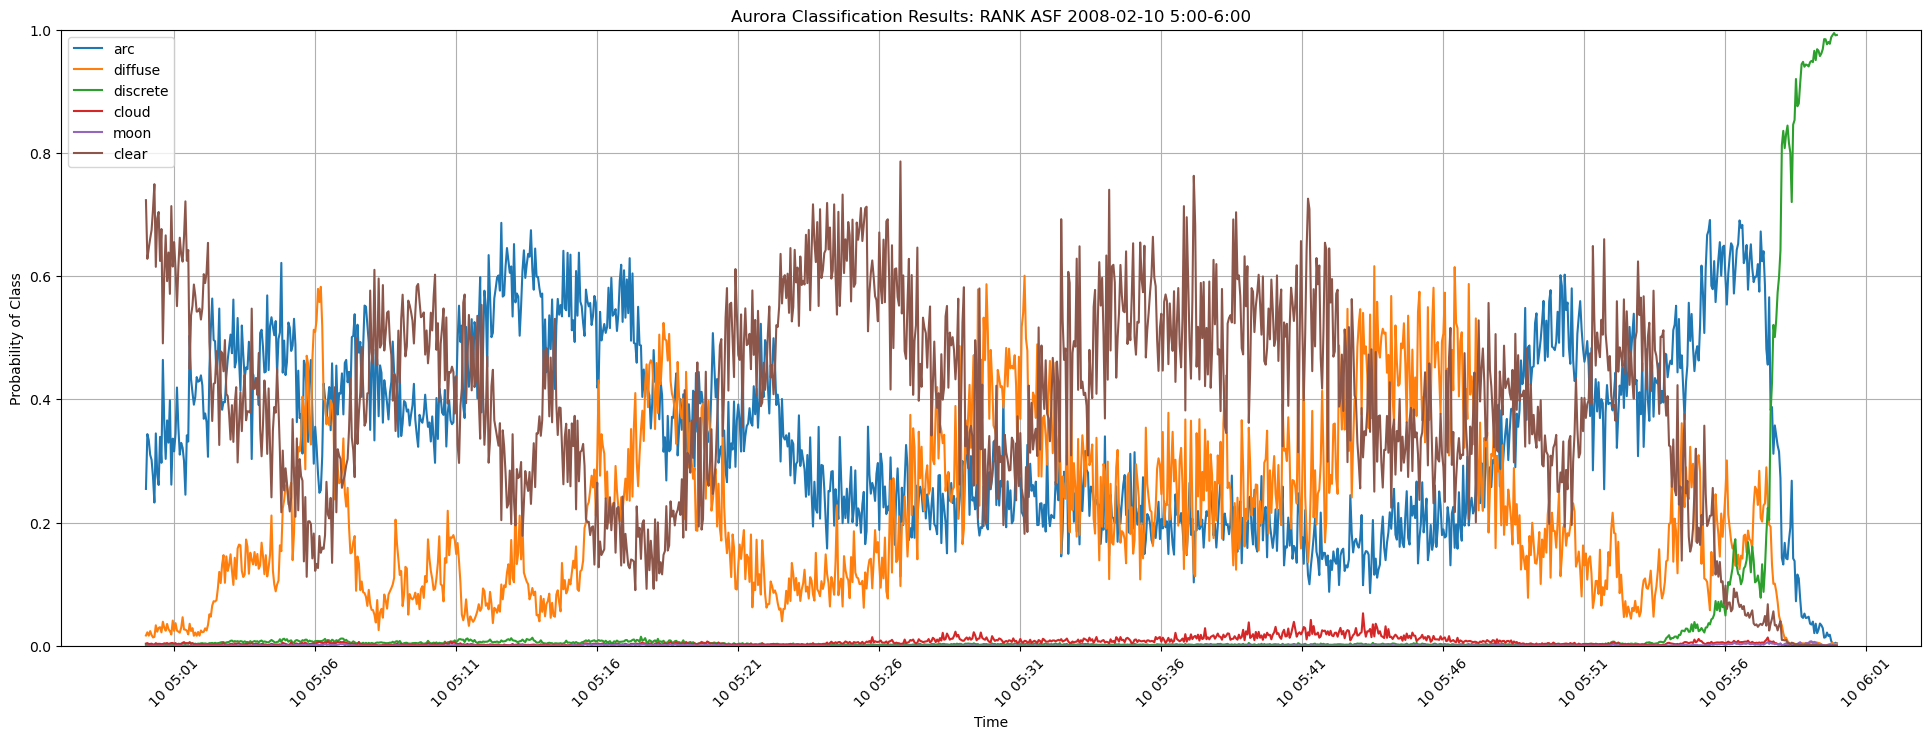

In [47]:
plot_probabilities_over_time(results)